In [1]:
import numpy as np
import cupy as cp
import ray
import astropy.units as u
from IPython.display import clear_output
import time
from pathlib import Path
from matplotlib.patches import Circle

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

import warnings
warnings.filterwarnings("ignore")

import misc

from poppy_roman_cgi_phasec import cgi

from importlib import reload
import copy

wavelength_c = 575e-9*u.m

nlam = 3
bandwidth = 0.10
minlam = wavelength_c * (1 - bandwidth/2)
maxlam = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minlam, maxlam, nlam )

iwa = 2.8
owa = 9.7

data_dir = Path('/groups/douglase/kians-data-files/poppy-cupy-tests-data')

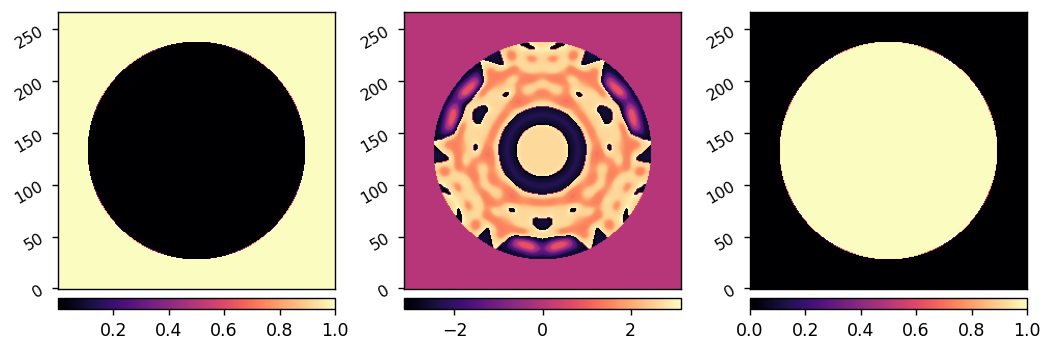

In [2]:
poppy.conf.use_cupy = True
poppy.conf.use_mkl = True
poppy.conf.use_fftw = True

poppy_log.disabled = True

reload(cgi)
hlc = cgi.CGI(cgi_mode='hlc', psf_pixelscale_lamD=0.2, npsf=128, use_pupil_defocus=True, use_opds=False)
hlc_opds = cgi.CGI(cgi_mode='hlc', psf_pixelscale_lamD=0.2, npsf=128, use_pupil_defocus=True, use_opds=True)

# Test monochromatic PSFs.

Propagating wavelength 575.000 nm.
PSF calculated in 0.286s


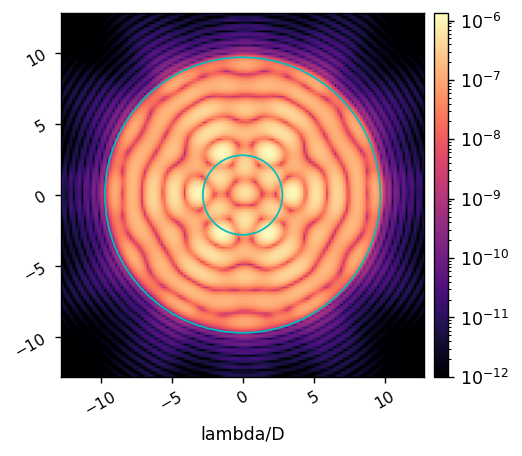

Saved data to:  /groups/douglase/kians-data-files/poppy-cupy-tests-data/hlc_gpu_wfs_mono


In [5]:
# Without OPDs
wf = hlc.calc_psf(quiet=False)

psf_mono = wf.intensity

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.myimshow(psf_mono, lognorm=True, pxscl=hlc.psf_pixelscale_lamD, patches=patches, vmin=1e-12)

if isinstance(psf_mono, np.ndarray):
    misc.save_pickle(data_dir/'hlc_cpu_wfs_mono', wf)
else:
    misc.save_pickle(data_dir/'hlc_gpu_wfs_mono', wf)

In [4]:
%%timeit
wf = hlc.calc_psf(quiet=True)

6.74 s ± 16.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Propagating wavelength 575.000 nm.
PSF calculated in 0.390s


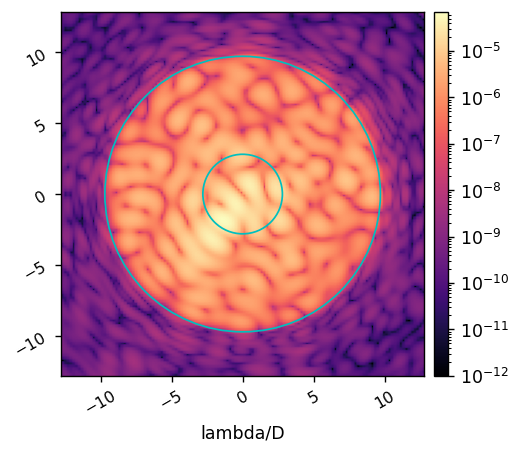

Saved data to:  /groups/douglase/kians-data-files/poppy-cupy-tests-data/hlc_gpu_wfs_mono_opds


In [6]:
# With OPDs
wf = hlc_opds.calc_psf(quiet=False)

psf_mono = wf.intensity

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.myimshow(psf_mono, lognorm=True, pxscl=hlc.psf_pixelscale_lamD, patches=patches, vmin=1e-12)

if isinstance(psf_mono, np.ndarray):
    misc.save_pickle(data_dir/'hlc_cpu_wfs_mono_opds', wf)
else:
    misc.save_pickle(data_dir/'hlc_gpu_wfs_mono_opds', wf)

In [6]:
%%timeit
wf = hlc_opds.calc_psf(quiet=True)

10.1 s ± 12.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Test broadband PSFs.

In [7]:
settings = hlc.copy_mode_settings(nlam)
for i,sett in enumerate(settings):
    sett.update({'wavelength':wavelengths[i]})
settings

[{'cgi_mode': 'hlc',
  'wavelength': <Quantity 5.4625e-07 m>,
  'npsf': 128,
  'psf_pixelscale': <Quantity 5.98e-06 m / pix>,
  'interp_order': 3,
  'offset': (0, 0),
  'use_fpm': True,
  'use_fieldstop': True,
  'use_pupil_defocus': True,
  'use_opds': False,
  'polaxis': 0,
  'return_intermediates': False},
 {'cgi_mode': 'hlc',
  'wavelength': <Quantity 5.75e-07 m>,
  'npsf': 128,
  'psf_pixelscale': <Quantity 5.98e-06 m / pix>,
  'interp_order': 3,
  'offset': (0, 0),
  'use_fpm': True,
  'use_fieldstop': True,
  'use_pupil_defocus': True,
  'use_opds': False,
  'polaxis': 0,
  'return_intermediates': False},
 {'cgi_mode': 'hlc',
  'wavelength': <Quantity 6.0375e-07 m>,
  'npsf': 128,
  'psf_pixelscale': <Quantity 5.98e-06 m / pix>,
  'interp_order': 3,
  'offset': (0, 0),
  'use_fpm': True,
  'use_fieldstop': True,
  'use_pupil_defocus': True,
  'use_opds': False,
  'polaxis': 0,
  'return_intermediates': False}]

In [8]:
hlc_actors = cgi.create_actors(ncpus=10, ngpus=1/3, settings=settings)

In [10]:
reload(cgi)
wfs = cgi.calc_psfs(hlc_actors, quiet=False)

(CGI pid=38328) Propagating wavelength 546.250 nm.
(CGI pid=38330) Propagating wavelength 603.750 nm.
(CGI pid=38329) Propagating wavelength 575.000 nm.


(CGI pid=38328) /home/u21/kianmilani/src/poppy/poppy/geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
(CGI pid=38328)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')
(CGI pid=38328) /home/u21/kianmilani/src/poppy/poppy/geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
(CGI pid=38328)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')
(CGI pid=38330) /home/u21/kianmilani/src/poppy/poppy/geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
(CGI pid=38330)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')
(CGI pid=38330) /home/u21/kianmilani/src/poppy/poppy/geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale

All PSFs calculated in 0.550s
(CGI pid=38328) PSF calculated in 0.531s
(CGI pid=38330) PSF calculated in 0.529s
(CGI pid=38329) PSF calculated in 0.530s


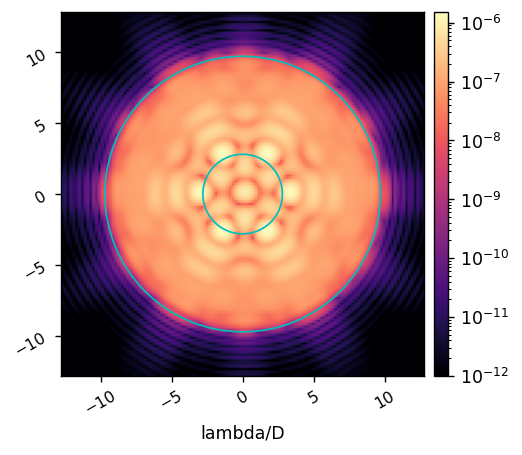

Saved data to:  /groups/douglase/kians-data-files/poppy-cupy-tests-data/hlc_gpu_wfs_broad


In [11]:
psf_broad = 0
for i in range(nlam):
    psf_broad += wfs[i].intensity/nlam

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.myimshow(psf_broad, lognorm=True, pxscl=hlc.psf_pixelscale_lamD, patches=patches, vmin=1e-12)

if isinstance(psf_broad, np.ndarray):
    misc.save_pickle(data_dir/'hlc_cpu_wfs_broad', wfs)
else:
    misc.save_pickle(data_dir/'hlc_gpu_wfs_broad', wfs)